In [16]:
import soundfile as sf
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from scipy.interpolate import interp1d
import soundfile as sf
from scipy.signal import resample_poly, spectrogram, butter, sosfilt

In [3]:
def plot_spectrogram(file_path, fmax=None, n_fft=1024):
    audio, fs = sf.read(file_path)
    # Collapse to mono
    if audio.ndim > 1:
        audio = audio[:,0]
    # Cap nperseg to signal length
    nperseg = min(n_fft, len(audio))
    hop_length = nperseg // 2
    noverlap   = nperseg - hop_length

    f, t, Sxx = signal.spectrogram(
        audio, fs=fs,
        nperseg=nperseg,
        noverlap=noverlap
    )
    Sdb = 10 * np.log10(Sxx + 1e-10)

    plt.pcolormesh(t, f, Sdb, shading='gouraud')
    if fmax:
        plt.ylim(0, fmax)
    plt.xlabel('Time [s]'); plt.ylabel('Frequency [Hz]')
    plt.colorbar(label='Intensity [dB]')
    plt.show()

In [ ]:
#check metadata in bash
#ffprobe -i "C:/Users/aleja/OneDrive/Desktop/mice maze/mouse_vocalisation/mM27.18-individuality_run1_day2-2016-10-14_15-16-00_0003.wav"

#ffmpeg -i "C:/Users/aleja/OneDrive/Desktop/mice maze/mouse_vocalisation/Figure 3 Audio 1.mp4" -vn -acodec pcm_s16le -ar 44100 -ac 2 "C:/Users/aleja/OneDrive/Desktop/mice maze/mouse_vocalisation/Figure 3 Audio 1.wav"


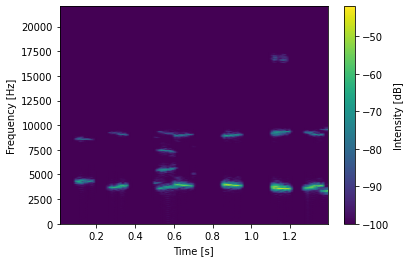

In [19]:
file_path = "C:/Users/aleja/OneDrive/Desktop/mice maze/mouse_vocalisation/Figure 3 Audio 1.wav"

plot_spectrogram(file_path)

In [4]:
file_path_mouse_fem_piss_1 = "C:/Users/aleja/OneDrive/Desktop/mice maze/mouse_vocalisation/mM27.18-individuality_run1_day2-2016-10-14_15-16-00_0003.wav"
#plot_spectrogram(file_path_mouse_fem_piss_1)

In [ ]:
file_path_mouse_fem_piss_2 = "C:/Users/aleja/OneDrive/Desktop/mice maze/mouse_vocalisation/mM3.5individuality_run3_day2-2016-10-28_17-05-14_0020.wav"
#plot_spectrogram(file_path_mouse_fem_piss_1)

In [2]:
def plot_usv_spectrogram(wav_path,
                         n_fft=512,
                         hop_length=128,
                         fmin=1000,  # 20 kHz
                         fmax=120000, # 125 kHz
                         cmap='cividis'):
    # 1. Load audio
    data, fs = sf.read(wav_path)
    if data.ndim > 1:
        data = data.mean(axis=1)

    # 2. Compute spectrogram (power spectral density)
    f, t, Sxx = signal.spectrogram(
        data,
        fs=fs,
        window='hann',
        nperseg=n_fft,
        noverlap=n_fft - hop_length,
        scaling='spectrum',
        mode='magnitude'
    )

    # 3. Limit to your USV band and convert to dB
    idx = np.logical_and(f >= fmin, f <= fmax)
    Sdb = 20 * np.log10(Sxx[idx, :] + 1e-10)
    f = f[idx] / 1e3  # convert to kHz for plotting

    # 4. Plot
    plt.figure(figsize=(6, 2))
    plt.pcolormesh(t, f, Sdb, shading='gouraud', cmap=cmap)
    plt.ylim(fmin/1e3, fmax/1e3)
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (kHz)")
    plt.title("USV Spectrogram")
    plt.colorbar(label="Amplitude (dB)")
    plt.tight_layout()
    plt.show()

In [1]:
plot_usv_spectrogram(file_path_mouse_fem_piss_1, cmap = "viridis")

NameError: name 'plot_usv_spectrogram' is not defined

In [5]:
def generate_voc_array(path_to_voc, sample_rate):
    '''this function retrieves the sound data from the .wav files and samples them down to a more readable 192KHz'''
    voc_sound_data = []
    voc, fs = sf.read(path_to_voc)

    if fs == sample_rate:
        #USVs might be sampled at 250KHz. Our sound card handles max 192KHz. Check for sample rate
        voc_sound_data.append([voc])

    elif fs > sample_rate: 
        # if sample rate is too high, we need to resample
        n_samples_new = int(len(voc) * sample_rate / fs)
        voc_resampled = resample(voc, n_samples_new)
        # Ensure dtype float32
        voc_resampled = voc_resampled.astype('float32')

        voc_sound_data.append(voc_resampled)
    else:
        print(f"The sample rate of this recording is {fs}, which is too low\n Please ensure that the fs is at least 192 KHz")

    print(voc_sound_data)
    return voc_sound_data

In [6]:
generate_voc_array(file_path_mouse_fem_piss_1, 192000)

[array([-0.00308822, -0.00015801, -0.00086481, ...,  0.00023772,
        0.00545693, -0.000707  ], dtype=float32)]


[array([-0.00308822, -0.00015801, -0.00086481, ...,  0.00023772,
         0.00545693, -0.000707  ], dtype=float32)]

In [7]:
voc, fs = sf.read(file_path_mouse_fem_piss_1)
print(fs)

300000


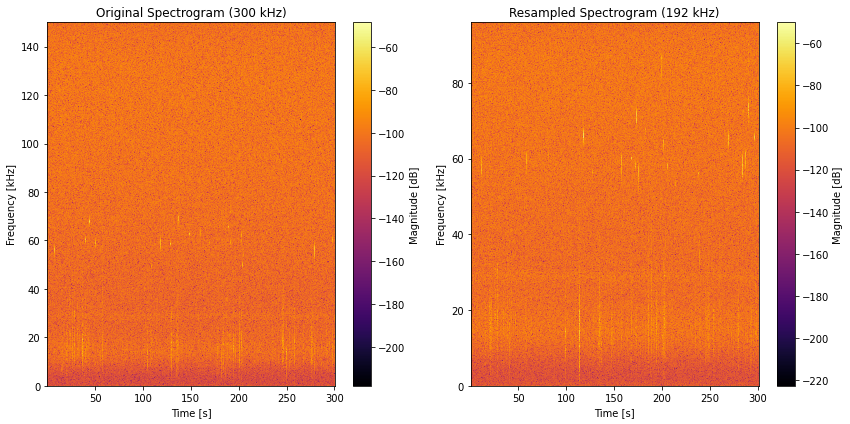

In [ ]:

path_to_voc = file_path_mouse_fem_piss_1
target_fs= 192000

# 1. Load and resample
voc_192k, fs_orig = generate_voc_array(path_to_voc, target_fs)

# 2. For comparison, also load the original (300kHz) signal
voc_orig, _ = sf.read(path_to_voc)   # voc_orig is at 300 kHz

# 3. Compute spectrogram of both signals
#    We'll use a window length (nperseg) that is fine enough to see ultrasonic structure;
#    e.g. window = 1024 samples → time‐resolution ≈ 1024/300000 ≈ 3.4 ms,
#    freq‐resolution ≈ 300k/1024 ≈ 293 Hz. You can adjust nperseg/hop accordingly.

nperseg_orig = 1024
noverlap_orig = nperseg_orig // 2
f1, t1, Sxx1 = spectrogram(voc_orig, fs=fs_orig,
                           nperseg=nperseg_orig, noverlap=noverlap_orig,
                           scaling='density', mode='magnitude')

nperseg_new = 1024
noverlap_new = nperseg_new // 2
f2, t2, Sxx2 = spectrogram(voc_192k, fs=target_fs,
                           nperseg=nperseg_new, noverlap=noverlap_new,
                           scaling='density', mode='magnitude')

# 4. Plot side by side
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.pcolormesh(t1, f1/1000, 20*np.log10(Sxx1+1e-12), shading='auto', cmap = "viridis")
plt.ylim(0, fs_orig/2/1000)  # up to Nyquist (150 kHz)
plt.title('Original Spectrogram (300 kHz)')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [kHz]')
plt.colorbar(label='Magnitude [dB]')

plt.subplot(1, 2, 2)
plt.pcolormesh(t2, f2/1000, 20*np.log10(Sxx2+1e-12), shading='auto', cmap = "viridis")
plt.ylim(0, target_fs/2/1000)  # up to Nyquist (96 kHz)
plt.title('Resampled Spectrogram (192 kHz)')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [kHz]')
plt.colorbar(label='Magnitude [dB]')

plt.tight_layout()
plt.show()


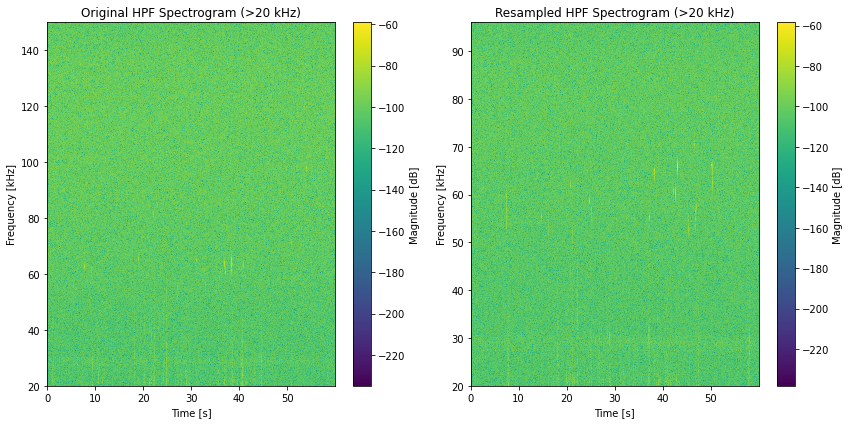

In [18]:
def highpass_filter(signal, fs, cutoff=20000, order=5):
    """
    Apply a Butterworth high-pass filter at 'cutoff' Hz to 'signal' sampled at 'fs' Hz.
    Uses an order-'order' filter in SOS form for numerical stability.
    """
    # Design: cutoff normalized to Nyquist
    sos = butter(order, cutoff / (fs / 2), btype='highpass', output='sos')
    filtered = sosfilt(sos, signal)
    return filtered

# 1. Load and resample signals
voc_orig, fs_orig = sf.read(path_to_voc)
voc_192k, fs_new = generate_voc_array(path_to_voc, target_fs)

# 2. (Optional) Limit to first 60 seconds
max_samples_orig = min(len(voc_orig), fs_orig * 60)
max_samples_new = min(len(voc_192k), fs_new * 60)
voc_orig_60s = voc_orig[:max_samples_orig]
voc_192k_60s = voc_192k[:max_samples_new]

# 3. Apply high-pass filter at 20 kHz to each
voc_orig_hp = highpass_filter(voc_orig_60s, fs_orig, cutoff=20000, order=6)
voc_192k_hp = highpass_filter(voc_192k_60s, fs_new, cutoff=20000, order=6)

# 4. Compute spectrograms for filtered signals
nperseg = 1024
noverlap = nperseg // 2

f1_hp, t1_hp, Sxx1_hp = spectrogram(voc_orig_hp, fs=fs_orig,
                                    nperseg=nperseg, noverlap=noverlap,
                                    scaling='density', mode='magnitude')

f2_hp, t2_hp, Sxx2_hp = spectrogram(voc_192k_hp, fs=fs_new,
                                    nperseg=nperseg, noverlap=noverlap,
                                    scaling='density', mode='magnitude')

# 5. Plot side by side, focusing only on frequencies above 20 kHz
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.pcolormesh(t1_hp, f1_hp/1000, 20 * np.log10(Sxx1_hp + 1e-12), shading='auto', cmap='viridis')
plt.ylim(20, fs_orig/2 / 1000)  # Start at 20 kHz
plt.xlim(0, min(60, t1_hp.max()))  # Up to 60 s
plt.title('Original HPF Spectrogram (>20 kHz)')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [kHz]')
plt.colorbar(label='Magnitude [dB]')

plt.subplot(1, 2, 2)
plt.pcolormesh(t2_hp, f2_hp/1000, 20 * np.log10(Sxx2_hp + 1e-12), shading='auto', cmap='viridis')
plt.ylim(20, fs_new/2 / 1000)  # Start at 20 kHz
plt.xlim(0, min(60, t2_hp.max()))  # Up to 60 s
plt.title('Resampled HPF Spectrogram (>20 kHz)')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [kHz]')
plt.colorbar(label='Magnitude [dB]')

plt.tight_layout()
plt.show()